# Vanguard Portfolio Optimizer

## Initialization

In [1]:
%matplotlib inline

In [2]:
import datetime
import json
import math
import typing
from typing import Any

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import polars as pl
import requests
import requests_cache
import seaborn as sns
from IPython.display import Image
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
requests_cache.install_cache("requests_cache", backend="sqlite")


def show(plot):
    """Hack to display plotly.express charts in github"""
    return Image(plot.to_image("png"))

In [4]:
PRODUCT_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-list.json"
REQUEST_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-port-specific-price-history.json?vars=portId:{port_id},issueType:S,startDate:{start_date:%Y-%m-%d},endDate:{end_date:%Y-%m-%d}"
ASSET_COLOURS = {"BOND": "red", "EQUITY": "green"}
CUTOFF_YEAR = 2017

END_DATE = datetime.datetime(2022, 12, 15)

## Get products descriptions

In [5]:
def get_products() -> dict:
    request = requests.get(PRODUCT_URL)
    assert request.status_code == 200
    return json.loads(request.text)


def len_or(value, none_value=1) -> int:
    return none_value if value is None else len(value)


def products_json_to_df(products_json: dict[str, dict[str, Any]]) -> pl.DataFrame:
    return pl.DataFrame(data=list(products_json.values())).with_columns(
        [
            pl.col("OCF").str.replace("%", "").cast(float).alias("fees"),
            pl.col("navOrMktPercentChange").str.replace("%", "").cast(float),
            pl.col("navOrMktPrice").cast(float),
            pl.col("navOrMktPriceAsOfDate").str.strptime(pl.Date, fmt="%d %b %Y"),
            pl.col("assetAllocations").arr.lengths().alias("assets"),
            pl.col("inceptionDate")
            .str.strptime(pl.Date, fmt="%Y-%m-%d")
            .alias("inception_date"),
            pl.col("risk").cast(int),
            pl.col("annualReturns").arr.eval(
                pl.element().str.replace("%", "").cast(float)
            ),
            pl.col("annualReturnsAsOfDate").arr.eval(
                pl.element().str.strptime(pl.Date, fmt="%d %b %Y")
            ),
        ]
    )


all_products_df = products_json_to_df(get_products())

In [6]:
port_id_to_sedols = dict(
    zip(all_products_df.get_column("portId"), all_products_df.get_column("sedol"))
)
sedol_to_name = dict(
    zip(all_products_df.get_column("sedol"), all_products_df.get_column("name"))
)

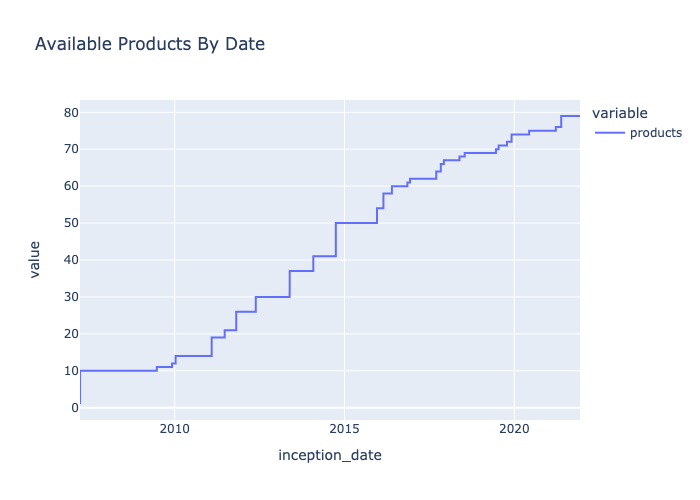

In [7]:
products_by_date = (
    all_products_df.groupby("inception_date")
    .agg([pl.count()])
    .sort("inception_date")
    .with_columns(pl.col("count").cumsum().alias("products"))
)


show(
    px.line(
        products_by_date.to_pandas(),
        x="inception_date",
        y=["products"],
        line_shape="vh",
        title="Available Products By Date",
    )
)

## Filter products

* Keep only "Accumulation" products (their dividends are automatically reinvsted)
* Remove actively managed products
* Remove ESG/SRI products (they are highly correlated to the non ESG/SRI products)
* Remove recently created products (not enough historical data)

In [8]:
products_df = all_products_df.filter(
    (pl.col("distributionStrategyType") == "ACCM")
    & pl.col("assetCode").is_in(["BOND", "EQUITY"])
    & (pl.col("managementType") == "INDEX")
    & ~pl.col("name").str.starts_with("ESG")
    & ~pl.col("name").str.starts_with("SRI")
    & (pl.col("inception_date").dt.year() <= CUTOFF_YEAR)
)

In [9]:
products_df[["name", "fees", "inception_date", "assetCode"]].sort(["fees"])

name,fees,inception_date,assetCode
str,f64,date,str
"""FTSE 100 Index...",0.06,2016-11-08,"""EQUITY"""
"""FTSE U.K. All ...",0.06,2009-12-04,"""EQUITY"""
"""U.S. Equity In...",0.1,2009-06-23,"""EQUITY"""
"""U.K. Short-Ter...",0.12,2013-05-22,"""BOND"""
"""Euro Investmen...",0.12,2014-01-31,"""BOND"""
"""Euro Governmen...",0.12,2014-01-31,"""BOND"""
"""Japan Governme...",0.12,2014-01-31,"""BOND"""
"""U.S. Investmen...",0.12,2014-01-31,"""BOND"""
"""U.S. Governmen...",0.12,2014-01-31,"""BOND"""


## Get products historical prices

In [10]:
histories = {}

for product in products_df.iter_rows(named=True):
    port_id = product["portId"]
    url = REQUEST_URL.format(
        port_id=port_id, start_date=product["inception_date"], end_date=END_DATE
    )
    request = requests.get(url)
    assert request.status_code == 200

    histories[port_id] = json.loads(request.text)

In [11]:
dfs = []
for port_id, history in histories.items():
    df = (
        pl.DataFrame(history)
        .with_columns(
            [
                pl.col("date").str.slice(0, 10).str.strptime(pl.Date),
                pl.lit(port_id).alias("portId"),
                pl.lit(port_id_to_sedols[port_id]).alias("sedol"),
            ]
        )
        .drop("mmNavPrice")
        .rename({"navPrice": "price"})
        .sort("date")
        .with_columns(pl.col("price").pct_change().alias("day_return"))
    )

    dfs.append(df)
historical_df = pl.concat(dfs).sort(["date", "sedol"])

## Explore products stats

In [12]:
pivoted_returns = historical_df.pivot(
    index=["date"], columns=["sedol"], values=["day_return"]
).drop_nulls()

In [13]:
yearly_returns_mean = (
    pivoted_returns.drop("date")
    .mean()
    .select([(pl.all() + 1.0).pow(252.0) - 1.0])
    .with_columns(pl.lit("return").alias("name"))
)

yearly_returns_std = (pivoted_returns.drop("date").std() * math.sqrt(252)).with_columns(
    pl.lit("std").alias("name")
)

stats = (
    pl.concat([yearly_returns_mean, yearly_returns_std])
    .melt(variable_name="sedol", id_vars="name")
    .pivot(values=["value"], columns=["name"], index=["sedol"])
)

In [14]:
products_stats_df = products_df.join(stats, on="sedol")

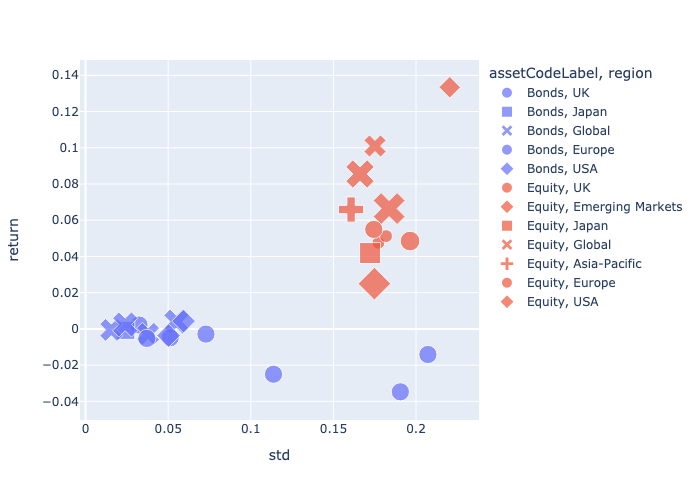

In [15]:
show(
    px.scatter(
        products_stats_df.to_pandas(),
        x="std",
        y="return",
        color="assetCodeLabel",
        symbol="region",
        size="fees",
    )
)

In [16]:
raw_pivoted_prices = historical_df.pivot(
    index="date", values="price", columns="sedol"
).drop_nulls()

In [17]:
pivoted_prices = (
    raw_pivoted_prices.drop(["date"])
    .select(pl.all() / pl.all().first())
    .rename({k: v for k, v in sedol_to_name.items() if k in raw_pivoted_prices.columns})
    .with_columns(raw_pivoted_prices.get_column("date"))
)

In [18]:
sorted_names = (
    pivoted_prices.select(pl.all().last())
    .drop("date")
    .melt()
    .sort("value", reverse=True)
    .get_column("variable")
    .to_list()
)

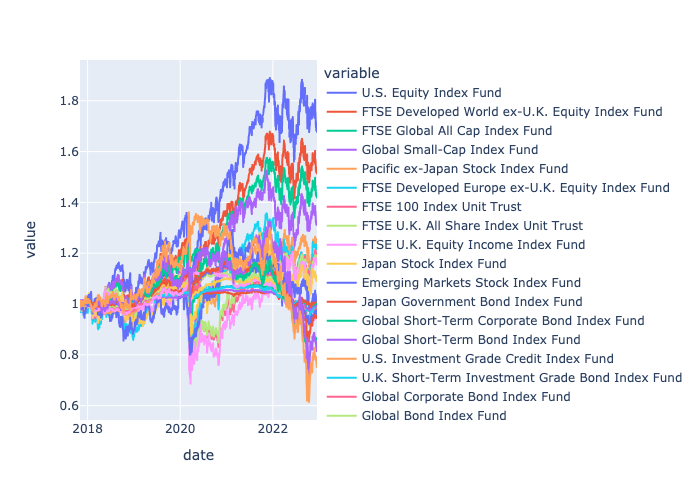

In [19]:
show(
    px.line(
        pivoted_prices.to_pandas(),
        x="date",
        y=sorted_names,
    )
)

## Prepare optimization inputs

In [20]:
covariance = pl.concat(
    [
        pivoted_returns.select(pl.cov(pl.exclude("date"), pl.col(col))).with_columns(
            pl.lit(col).alias("sedol")
        )
        for col in pivoted_returns.drop("date").columns
    ]
)
correlation = covariance.select(
    [
        pl.exclude("date")
        / pivoted_returns.select(pl.cov(pl.exclude("date"), pl.exclude("date"))).melt()[
            "value"
        ]
    ]
)
expected_returns = pivoted_returns.select(pl.exclude("date").mean())

In [21]:
class ProblemVariables:
    def __init__(self, expected_returns: pl.DataFrame, covariance: pl.DataFrame):
        assert expected_returns.columns == covariance.drop(["sedol"]).columns
        self.index = expected_returns.columns
        er = expected_returns.melt().get_column("value").to_numpy()
        cov = np.asmatrix(covariance.drop(["sedol"]).to_numpy())
        self.x = cp.Variable(len(er))
        self.vol = cp.quad_form(self.x, np.asmatrix(cov))
        self.ret = er.T @ self.x

    def results(self):
        return self.ret.value, self.std()

    def std(self):
        return math.sqrt(self.vol.value)

    def year_std(self):
        return self.std() * math.sqrt(252)

    def year_return(self):
        return (1 + self.ret.value) ** 252 - 1

    def full_results(self):
        names = list(self.index) + ["return", "std"]
        values = list(self.x.value) + [self.year_return(), self.year_std()]
        return pl.DataFrame(data=[values], schema=names, orient="row")

    def maximize_returns(self):
        cp.Problem(cp.Maximize(self.ret), [sum(self.x) == 1, self.x >= 0]).solve(
            solver="CVXOPT"
        )
        return self

    def minimize_std(self):
        cp.Problem(cp.Minimize(self.vol), [sum(self.x) == 1, self.x >= 0]).solve(
            solver="CVXOPT"
        )
        return self

    def solve_for_std(self, std_limit):
        cp.Problem(
            cp.Maximize(self.ret),
            [
                self.vol <= std_limit**2,
                cp.sum(self.x) == 1,
                self.x >= 0,
            ],
        ).solve(solver="CVXOPT")
        return self

    def iterate_stds(self, points):
        min_std = self.minimize_std().std()
        max_std = self.maximize_returns().std()

        std_values = np.linspace(min_std, max_std, points)
        results = []
        for std_limit in std_values:
            results.append(self.solve_for_std(std_limit).full_results())
        return pl.concat(results)
        # return pl.DataFrame(results)

    def solve_for_return(self, return_limit):
        prob = cp.Problem(
            cp.Minimize(self.vol),
            [
                self.ret >= return_limit,
                cp.sum(self.x) == 1,
                self.x >= 0,
            ],
        ).solve(solver="CVXOPT")
        return self

    def iterate_returns(self, points):
        min_return = self.minimize_std().ret.value
        max_return = self.maximize_returns().ret.value

        return_values = np.linspace(min_return, max_return, points)

        results = []
        for return_value in return_values:
            results.append(self.solve_for_return(return_value).full_results())
        return pl.DataFrame(results)


std_ptfs = (
    ProblemVariables(expected_returns, covariance).minimize_std().iterate_stds(200)
)

## Plot results

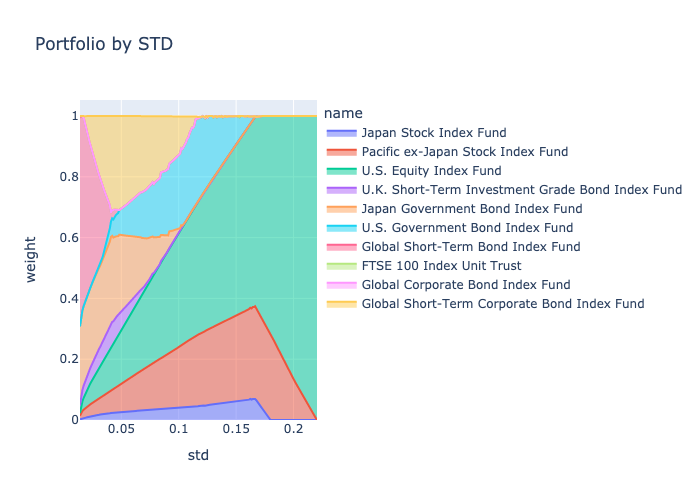

In [22]:
df = (
    std_ptfs.drop("return")
    .melt(id_vars="std", variable_name="sedol", value_name="weight")
    .filter(pl.col("weight") > 0.001)
    .join(products_df.select(["sedol", "name"]), on="sedol")
    .to_pandas()
)
show(px.area(df, x="std", y="weight", color="name", title="Portfolio by STD"))

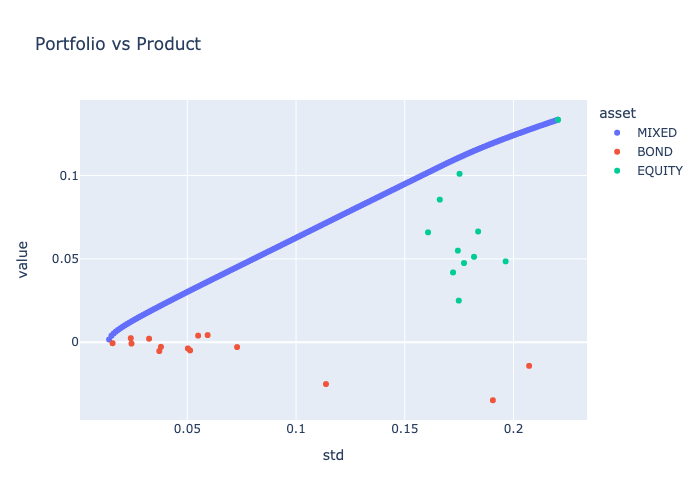

In [23]:
show(
    px.scatter(
        pl.concat(
            [
                std_ptfs.select(["return", "std"]).with_columns(
                    [
                        pl.lit("portfolio").alias("name"),
                        pl.lit("MIXED").alias("asset"),
                    ]
                ),
                products_stats_df.select(["return", "std", "name", "assetCode"]).rename(
                    {
                        "assetCode": "asset",
                    }
                ),
            ]
        ).to_pandas(),
        x="std",
        y=["return"],
        color="asset",
        title="Portfolio vs Product",
        hover_data=["name"],
    )
)

# Appendix 1: identifying redundant products

In [24]:
(
    pl.DataFrame(
        {
            sedol: variance_inflation_factor(pivoted_returns.drop("date").to_numpy(), i)
            for i, sedol in enumerate(pivoted_returns.drop("date").columns)
        },
    )
    .melt(variable_name="sedol", value_name="vif")
    .sort("vif")
    .join(products_df.select(["sedol", "name"]), on="sedol", how="left")
    # .select(['name', 'vif'])
    .to_pandas()
    .set_index("name")
)

,sedol,vif
name,,
Japan Government Bond Index Fund,BFRTD94,1.184855
U.K. Short-Term Investment Grade Bond Index Fund,B9M1BB1,1.725158
Global Short-Term Corporate Bond Index Fund,BDFB763,3.108723
U.K. Inflation-Linked Gilt Index Fund,B45Q903,3.507718
U.K. Investment Grade Bond Index Fund,B1S74Q3,3.567619
U.S. Investment Grade Credit Index Fund,BFRTDC7,3.671952
Euro Investment Grade Bond Index Fund,BFRTD83,3.829593
Pacific ex-Japan Stock Index Fund,B523L31,3.838147
Global Corporate Bond Index Fund,BDFB5M5,4.231303


In [25]:
def calculate_vifs(pivoted_returns):
    removed = {}
    for i in range(len(pivoted_returns.columns) - 1):
        vifs = (
            pl.DataFrame(
                {
                    sedol: variance_inflation_factor(pivoted_returns.to_numpy(), i)
                    for i, sedol in enumerate(pivoted_returns.columns)
                },
            )
            .melt(variable_name="sedol", value_name="vif")
            .sort("vif", reverse=True)
        )
        removed[vifs[0, "sedol"]] = [vifs[0, "vif"]]

        pivoted_returns = pivoted_returns.select(
            [c for c in pivoted_returns.columns if c not in removed]
        )
    removed[pivoted_returns.columns[0]] = 1
    return pl.DataFrame(removed).melt(variable_name="sedol", value_name="vif")


recursive_vifs = (
    calculate_vifs(pivoted_returns.drop("date"))
    .join(products_df.select(["sedol", "name"]), on="sedol", how="left")
    .sort("vif")
)

recursive_vifs.to_pandas().set_index("name")

,sedol,vif
name,,
FTSE U.K. Equity Income Index Fund,B59G4H8,1.000000
Japan Government Bond Index Fund,BFRTD94,1.000223
U.K. Short-Term Investment Grade Bond Index Fund,B9M1BB1,1.004772
Japan Stock Index Fund,B50MZ94,1.055015
U.S. Investment Grade Credit Index Fund,BFRTDC7,1.168504
U.S. Equity Index Fund,B5B71Q7,1.260143
U.K. Inflation-Linked Gilt Index Fund,B45Q903,1.354420
Emerging Markets Stock Index Fund,B50MZ72,1.670256
Euro Investment Grade Bond Index Fund,BFRTD83,1.781453


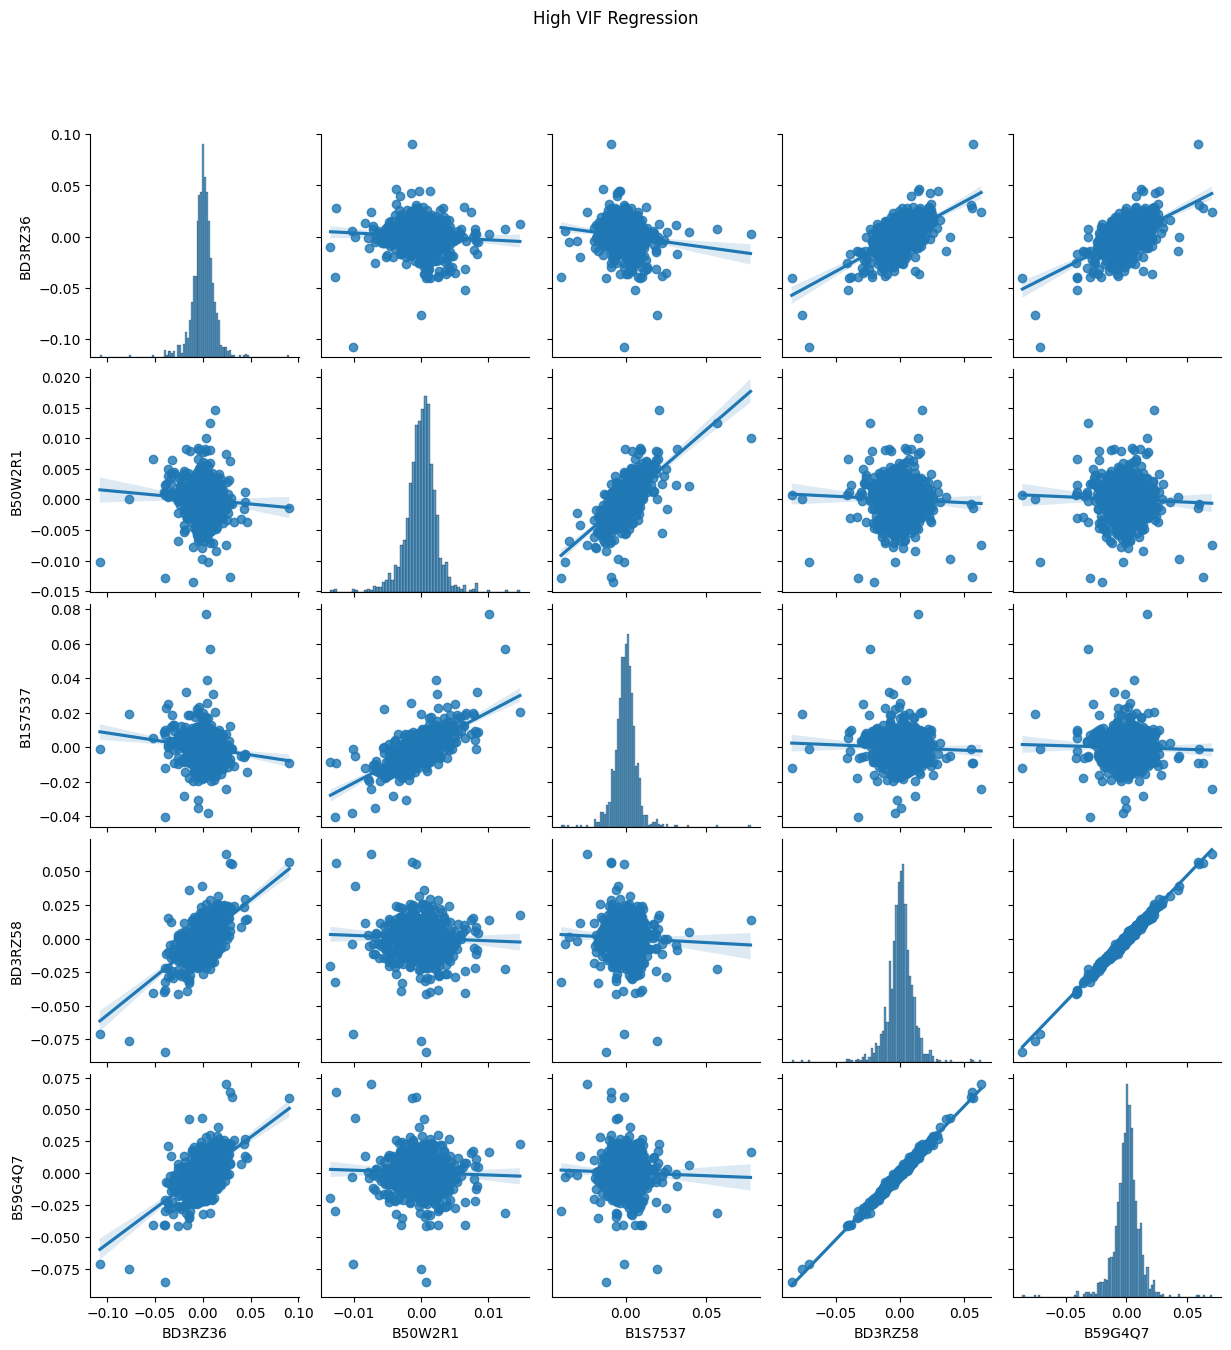

In [26]:
ax = sns.pairplot(
    pivoted_returns.select(recursive_vifs["sedol"].tail(5).to_list()).to_pandas(),
    kind="reg",
)
_ = ax.fig.suptitle("High VIF Regression", y=1.08)

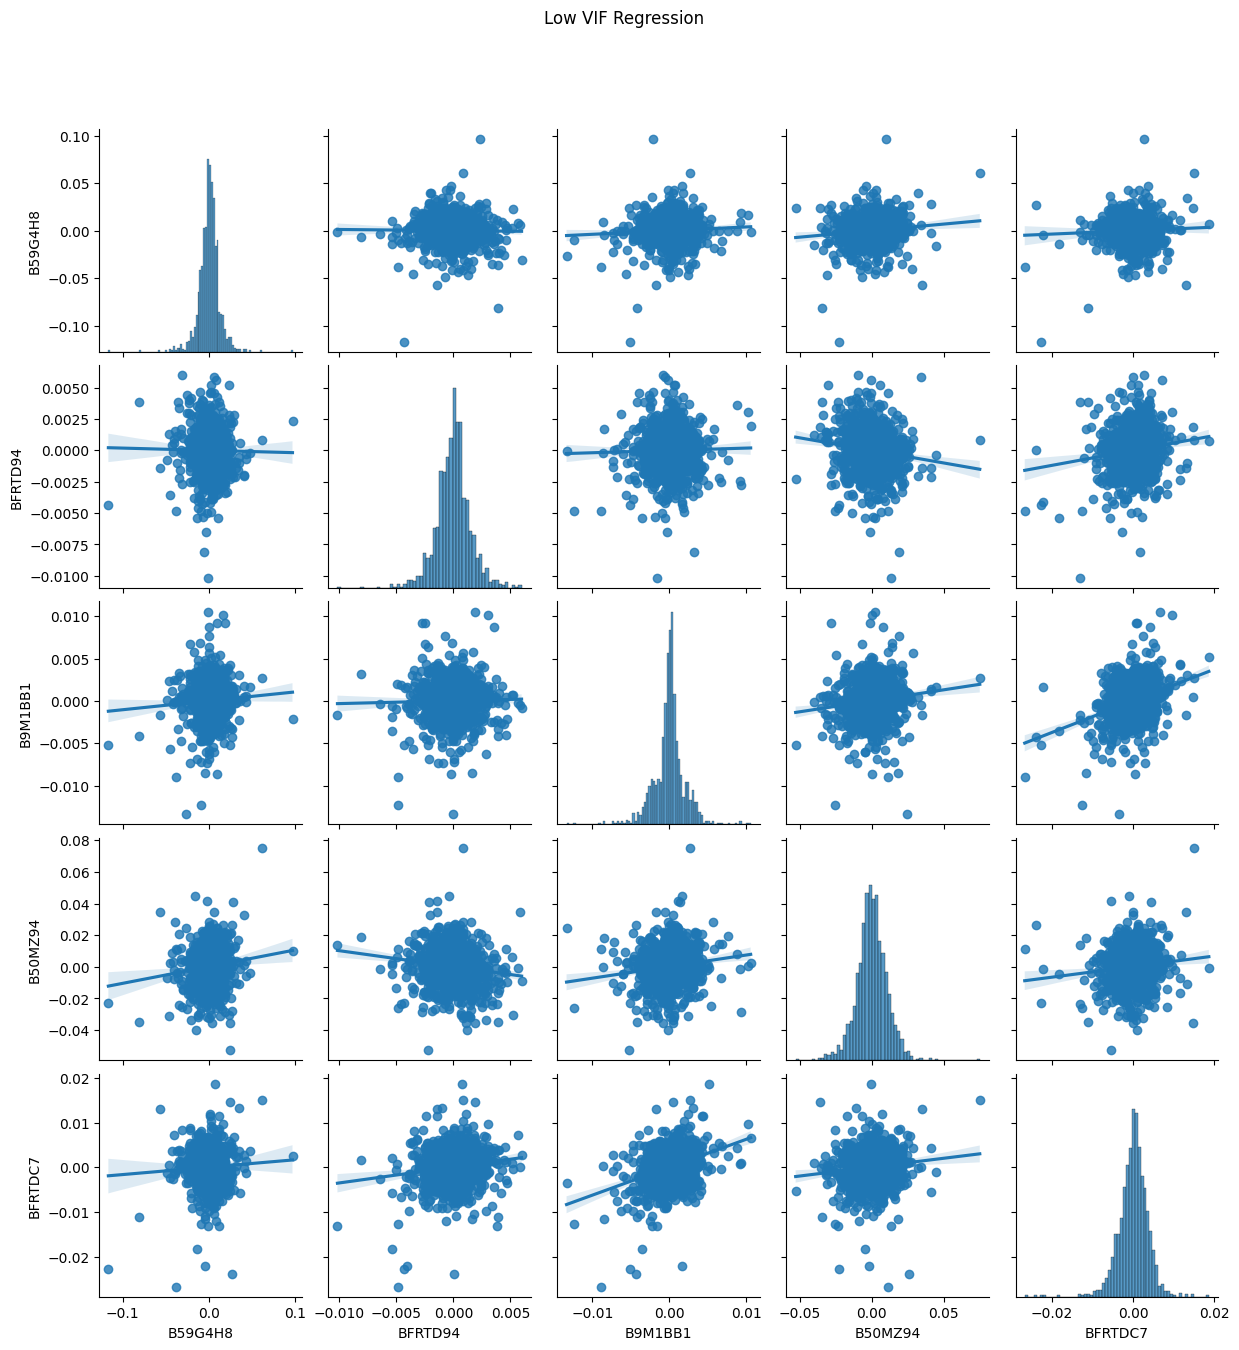

In [27]:
ax = sns.pairplot(
    pivoted_returns.select(recursive_vifs["sedol"].head(5).to_list()).to_pandas(),
    kind="reg",
)
_ = ax.fig.suptitle("Low VIF Regression", y=1.08)

# Appendix 2: Heat Map

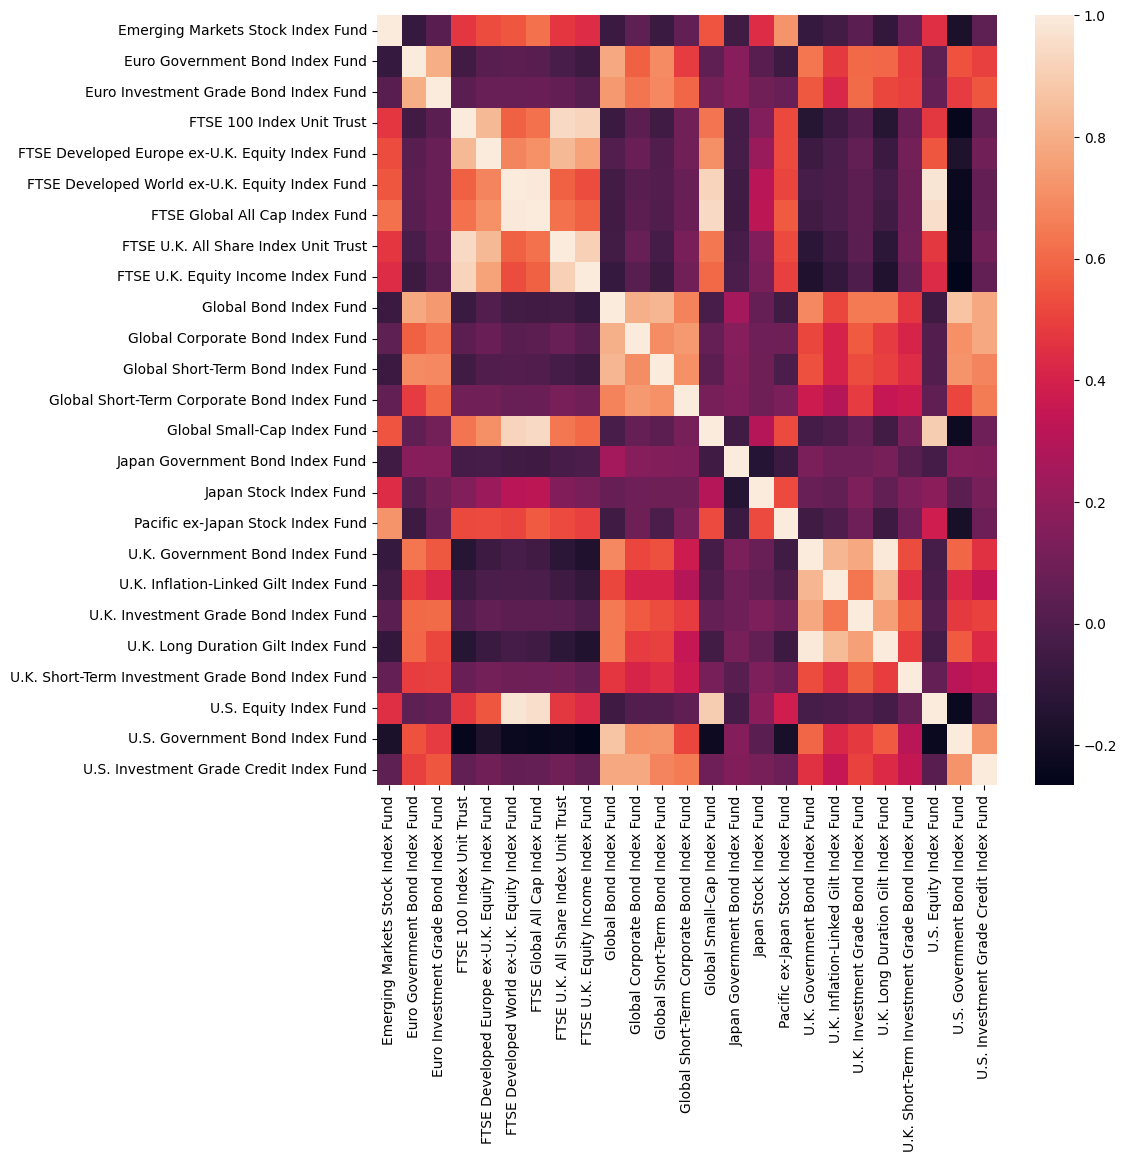

In [28]:
correlation = (
    pivoted_returns.drop("date")
    .rename(
        {
            sedol: name
            for sedol, name in sedol_to_name.items()
            if sedol in pivoted_returns.columns
        }
    )
    .to_pandas()
    .corr()
    .sort_index()[lambda x: sorted(x.columns)]
)
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(correlation, ax=ax)

# Appendix 3: PCA

In [29]:
returns_by_name = pivoted_returns.drop("date").rename(
    {
        sedol: name
        for sedol, name in sedol_to_name.items()
        if sedol in pivoted_returns.columns
    }
)

components_number = 7
pca = PCA(n_components=components_number)
X = returns_by_name.to_numpy().T
X = X / X.std()
components = pca.fit_transform(X)
principal_df = pl.DataFrame(
    data=components, schema=[str(i + 1) for i in range(0, components_number)]
).with_columns(pl.Series(returns_by_name.schema.keys()).alias("name"))

principal_df.to_pandas().set_index("name")

,1,2,3,4,5,6,7
name,,,,,,,
U.K. Investment Grade Bond Index Fund,16.622741,-1.250318,-0.037928,-1.681027,-0.287505,-0.632247,-3.209728
U.K. Government Bond Index Fund,25.819324,6.849782,-7.094163,2.388486,0.288404,0.453185,-6.860808
Emerging Markets Stock Index Fund,-16.617130,-2.165548,13.808994,18.777061,-20.370349,7.868937,-0.043883
Japan Stock Index Fund,0.603119,-1.289005,24.189111,24.088364,21.925228,1.873257,1.188195
Global Bond Index Fund,14.102045,-5.022739,4.650758,-6.843999,-0.316220,0.527919,0.372168
Pacific ex-Japan Stock Index Fund,-13.251822,-6.501651,10.633603,19.811018,-8.336423,-12.707681,-2.756460
FTSE U.K. Equity Income Index Fund,-28.353474,-19.299644,-18.381785,0.537000,2.657541,-7.326898,-0.755577
FTSE Developed World ex-U.K. Equity Index Fund,-25.723384,19.470292,3.578084,-4.640739,1.529914,0.081888,0.051732
FTSE Developed Europe ex-U.K. Equity Index Fund,-24.026477,-6.956612,-11.081482,2.207945,2.039791,15.550978,0.152246


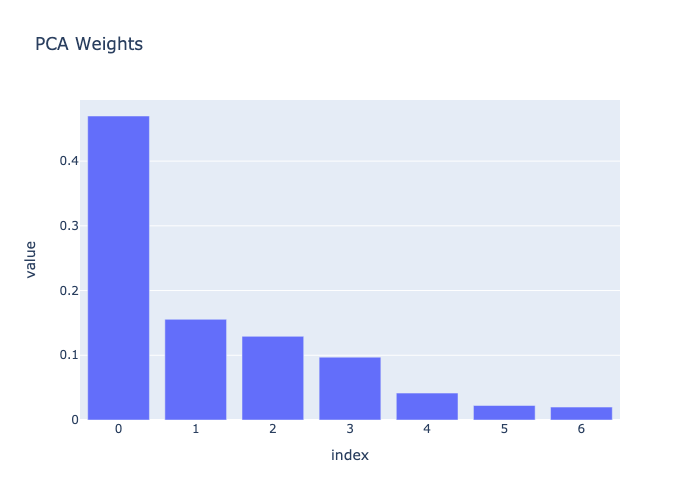

In [30]:
weights = pl.Series(pca.explained_variance_ratio_)
show(px.bar(weights.to_pandas(), title="PCA Weights"))